In [ ]:
# env init
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy import histogram
from sklearn.cluster import MiniBatchKMeans

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
# match dataset with csv
dataset_path="./Aerial_Landscapes"
categories=[d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

image_paths = []
image_labels = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(os.path.abspath(image_path).replace('\\','/')) # use absolute path
        image_labels.append(category)

dataframe = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})


print(f'Dataframe shape: {dataframe.shape}')

# save to csv
dataframe.to_csv('dataset.csv', index=False)

# test show
print(dataframe.head(5))

Dataframe shape: (12000, 2)
                                          image_path        label
0  e:/repo/SIFT-KNN/Aerial_Landscapes/Agriculture...  Agriculture
1  e:/repo/SIFT-KNN/Aerial_Landscapes/Agriculture...  Agriculture
2  e:/repo/SIFT-KNN/Aerial_Landscapes/Agriculture...  Agriculture
3  e:/repo/SIFT-KNN/Aerial_Landscapes/Agriculture...  Agriculture
4  e:/repo/SIFT-KNN/Aerial_Landscapes/Agriculture...  Agriculture


In [ ]:
# split dataset into training, validation, and test sets


# split the dataframe into training 70%, validation 15%, and test 15%
# include shuffle in train_test_split
train_df, temp_df = train_test_split(dataframe, test_size=0.3, random_state=42, stratify=dataframe['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# test show
# print(f'Train shape: {train_df.shape}')
# print(f'Validation shape: {val_df.shape}')
# print(f'Test shape: {test_df.shape}')


In [4]:
# SIFT for getting keypoints and descriptors
sift = cv2.SIFT_create()

# save sift descriptors and keypoints
sift_descriptors_list = []
sift_keypoints_list = []

# start sift, only on train df
for index, row in train_df.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is not None and descriptors.ndim == 2:
        sift_descriptors_list.append(descriptors)
        sift_keypoints_list.append(keypoints)

# show number of keypoints and descriptors
print(f'Number of keypoints and descriptors: {len(sift_descriptors_list)}')
print(f'Number of keypoints and descriptors: {len(sift_keypoints_list)}')

Number of keypoints and descriptors: 8338
Number of keypoints and descriptors: 8338


In [ ]:
# build boW


# flatten the list of descriptors and fit kmeans
if sift_descriptors_list:
    all_descriptors = np.vstack(sift_descriptors_list)
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)
    
def get_bow_features(dataframe,image_path, kmeans):
    x_temp= []
    y_temp= []

    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row['label'])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)

    x_train.append(histogram)
    y_train.append(row['label'])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val, y_val = get_bow_features(val_df, image_path, kmeans)
x_test, y_test = get_bow_features(test_df, image_path, kmeans)




d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [ ]:
# start training, by KNN


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# test the model on test set
y_pred = knn.predict(x_test)

# try on validation set
y_val_pred = knn.predict(x_val)


Accuracy: 0.50
              precision    recall  f1-score   support

 Agriculture       0.53      0.40      0.46       120
     Airport       0.35      0.48      0.40       120
       Beach       0.57      0.23      0.33       120
        City       0.33      0.88      0.48       120
      Desert       0.51      0.28      0.36       120
      Forest       0.64      0.92      0.75       120
   Grassland       0.65      0.30      0.41       120
     Highway       0.48      0.47      0.48       120
        Lake       0.30      0.20      0.24       120
    Mountain       0.54      0.79      0.64       120
     Parking       0.90      0.78      0.84       120
        Port       0.85      0.28      0.42       120
     Railway       0.48      0.74      0.58       120
 Residential       0.59      0.60      0.59       120
       River       0.41      0.18      0.25       120

    accuracy                           0.50      1800
   macro avg       0.54      0.50      0.48      1800
weighted av

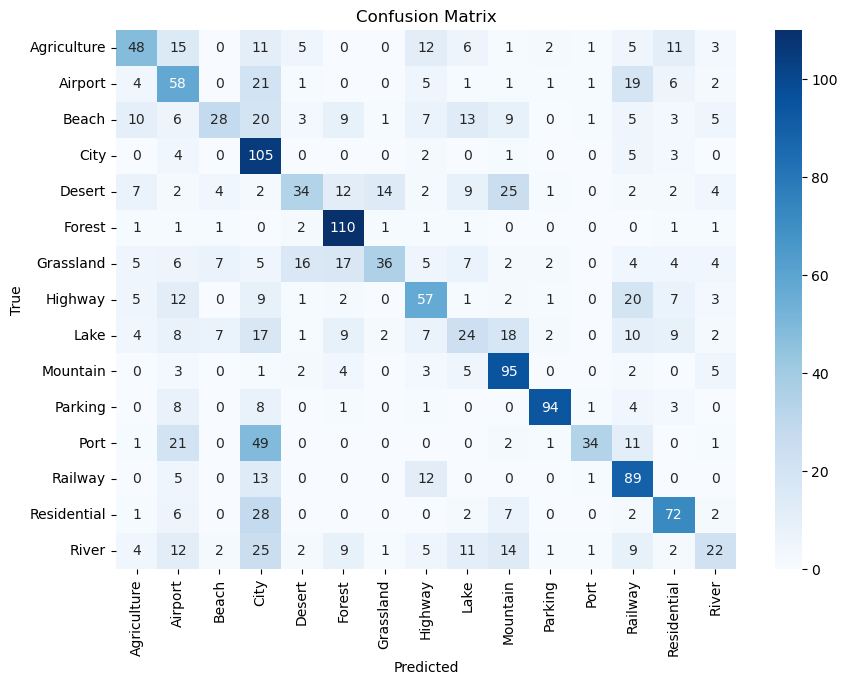

In [ ]:
# show results by plt


# show accuracy
accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))
# show confusion matrix

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Validation Accuracy:  0.51
              precision    recall  f1-score   support

 Agriculture       0.58      0.44      0.50       120
     Airport       0.34      0.49      0.40       120
       Beach       0.54      0.23      0.33       120
        City       0.33      0.81      0.47       120
      Desert       0.59      0.37      0.45       120
      Forest       0.71      0.91      0.80       120
   Grassland       0.72      0.42      0.53       120
     Highway       0.38      0.38      0.38       120
        Lake       0.29      0.22      0.25       120
    Mountain       0.58      0.81      0.68       120
     Parking       0.93      0.71      0.81       120
        Port       0.94      0.37      0.53       120
     Railway       0.42      0.67      0.51       120
 Residential       0.63      0.62      0.62       120
       River       0.38      0.22      0.28       120

    accuracy                           0.51      1800
   macro avg       0.56      0.51      0.50      1800

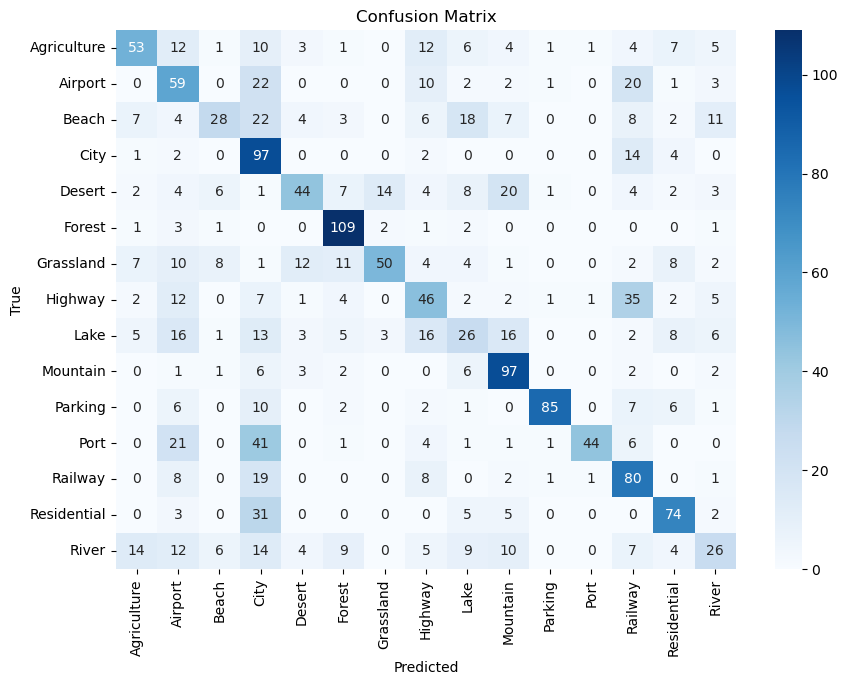

In [17]:
# val results
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=categories))
# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_val, y_val_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
